# **Problem 5: Getting to Know Some of the Simplified JPEG Compression Steps**

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

# A.

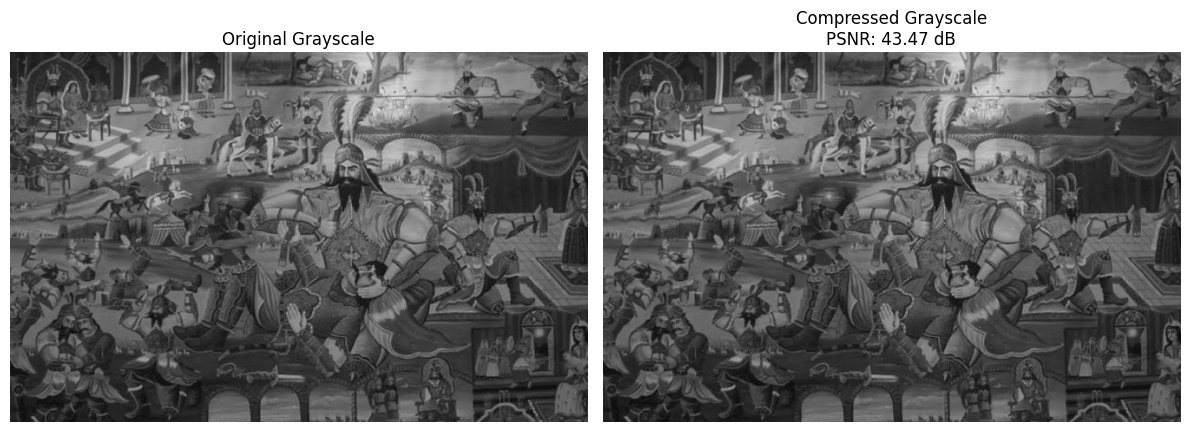

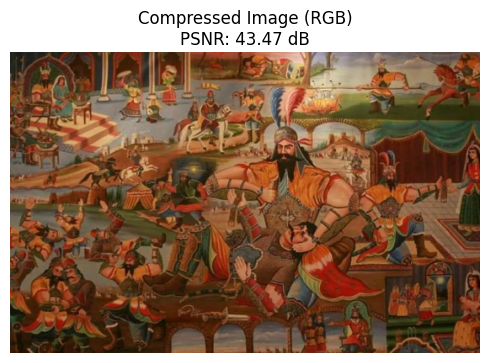

In [ ]:
# Image padding
def pad_image(image, block_size):
    h, w = image.shape[:2]

    # Calculate padding for height and width
    pad_h = (block_size - h % block_size) % block_size
    pad_w = (block_size - w % block_size) % block_size
    if len(image.shape) == 3:
        padded = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')
    else:
        padded = np.pad(image, ((0, pad_h), (0, pad_w)), mode='reflect')
    return padded, h, w

# DCT compression by largest coefficients
def compress_dct_by_magnitude(channel, block_size=4, discard_ratio=0.75):
    padded, orig_h, orig_w = pad_image(channel, block_size)
    h, w = padded.shape
    compressed = np.zeros_like(padded, dtype=np.float32)

    num_coeffs = block_size * block_size
    keep_coeffs = int(num_coeffs * (1 - discard_ratio))

    # Process image blocks
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = padded[i:i+block_size, j:j+block_size].astype(np.float32) - 128
            dct_block = cv2.dct(block)

            # Select top coefficients
            flat = dct_block.flatten()
            idx = np.argsort(np.abs(flat))[::-1]  
            mask = np.zeros_like(flat)
            mask[idx[:keep_coeffs]] = 1
            filtered = flat * mask
            filtered_dct = filtered.reshape((block_size, block_size))

            idct_block = cv2.idct(filtered_dct) + 128
            compressed[i:i+block_size, j:j+block_size] = idct_block

    compressed = np.clip(compressed[:orig_h, :orig_w], 0, 255).astype(np.uint8)
    return compressed

# Compress image using DCT on YCrCb channels
def apply_dct_compression(image_path, block_size=4, discard_ratio=0.75):
    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        raise ValueError("Image not found!")

    image_ycc = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(image_ycc)

    # Compress each channel
    y_compressed = compress_dct_by_magnitude(y, block_size, discard_ratio)
    cr_compressed = compress_dct_by_magnitude(cr, block_size, discard_ratio * 0.5)
    cb_compressed = compress_dct_by_magnitude(cb, block_size, discard_ratio * 0.5)

    # Merge channels and convert to RGB
    compressed_ycc = cv2.merge((y_compressed, cr_compressed, cb_compressed))
    compressed_rgb = cv2.cvtColor(compressed_ycc, cv2.COLOR_YCrCb2RGB)

    psnr_value = psnr(y, y_compressed, data_range=255)   # Calculate PSNR

    # Show original and compressed images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(y, cmap='gray', vmin=0, vmax=255)
    plt.title('Original Grayscale')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(y_compressed, cmap='gray', vmin=0, vmax=255)
    plt.title(f'Compressed Grayscale\nPSNR: {psnr_value:.2f} dB')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Show compressed RGB image
    plt.figure(figsize=(5, 5))
    plt.imshow(compressed_rgb)
    plt.title(f"Compressed Image (RGB)\nPSNR: {psnr_value:.2f} dB")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    cv2.imwrite('compressed_rgb_result.jpg', cv2.cvtColor(compressed_rgb, cv2.COLOR_RGB2BGR))
    return compressed_rgb

compressed_rgb_image = apply_dct_compression('shahnameh.png', block_size=4, discard_ratio=0.75)